In [43]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
# It is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# from sklearn.cluster import KMeans


import plotly as py
# Plotly provides online graphing, analytics, and statistics tools
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb

In [57]:
all_data = pd.read_csv("customer_segmentation.csv",encoding='cp1252')

In [58]:
all_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Features

In [59]:
all_data['InvoiceDate'] = pd.to_datetime(all_data['InvoiceDate'])
all_data.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom


In [60]:
all_data['YearMonth'] = all_data['InvoiceDate'].map(lambda d: d.year*100+d.month)
all_data.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012


In [61]:
all_data['Country'].value_counts()
# Selecting UK as it is having the most data

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [62]:
all_uk = all_data[all_data["Country"]=='United Kingdom']#.dropna()
all_uk.shape

(495478, 9)

In [63]:
all_uk.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012


# Segmentation Techniques
##### i.e. clustering the customers as:
##### Low value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
##### Mid value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
##### High value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

==>So we need to calculate the RFM(Recency, Frequency and Monetary Value) and apply Unsupervised Learning.

In [64]:
len(all_uk['CustomerID'].unique())

3951

#### Making the dataset

In [65]:
all_user = pd.DataFrame(all_data['CustomerID'].unique(),columns=['CustomerID'])
all_user.head(2)

,CustomerID
0,17850.0
1,13047.0


#### Calculating Recency

In [66]:
uk_recency = all_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
uk_recency.columns = ['CustomerID','lastdate']  # Recency = last purchase date of a user
uk_recency.head(2)

,CustomerID,lastdate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00


In [67]:
overall_lastdate = uk_recency['lastdate'].max()
overall_lastdate

Timestamp('2011-12-09 12:49:00')

In [70]:
uk_recency['Recency'] = (overall_lastdate - uk_recency['lastdate']).dt.days
uk_recency.head(2)

,CustomerID,lastdate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1


In [72]:
all_user = pd.merge(all_user, uk_recency[['CustomerID','Recency']])
all_user.head(2)

,CustomerID,Recency
0,17850.0,301
1,13047.0,31


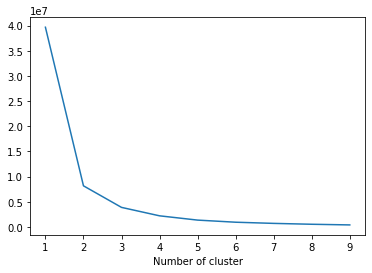

In [73]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = all_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()